In [54]:
import BenchmarkTools: @btime, @benchmark;

import Pkg: activate, build
activate("../GSHEIntegrator/.")
import GSHEIntegrator;


import Plots
using LaTeXStrings
using Measures
using NPZ
using EllipsisNotation

  Activating project at `~/Projects/birefringence/GSHEIntegrator`


Setup the problem geometry

In [19]:
Nsols = 2

ϵs = (10).^LinRange(-3, -1, 20)
geometry = GSHEIntegrator.setup_geometry(
   rsource=5, θsource=0.5π, ϕsource=0,
   robs=25, θobs=0.4π, ϕobs=π,
   a=0.99)

GSHEIntegrator.Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: GSHEIntegrator.SphericalCoords{Float64}
  observer: GSHEIntegrator.SphericalCoords{Float64}
  direction_coords: Symbol spherical
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 0.0
  redshift: Float64 0.0
  nloops: Float64 0.0
  ode_options: GSHEIntegrator.ODESolverOptions
  opt_options: GSHEIntegrator.OptimiserOptions
  postproc_options: GSHEIntegrator.PostprocOptions


Solve a geodesic/GSHE trajectory in pointing in an initial direction $\psi=0.2, \rho=0.3$

In [26]:
p0 = [0.2, 0.3]
geodesic_sol = GSHEIntegrator.solve_problem(p0, geometry, 0, 2; save_everystep=true)
# GSHE at ϵ=0.1 for s=2
gshe_sol = GSHEIntegrator.solve_problem(p0, geometry, 0.1, 2; save_everystep=true);

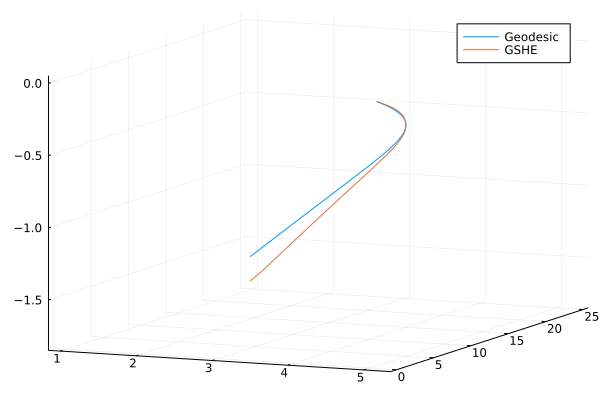

In [27]:
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)

fig = Plots.plot()
Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic")
Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]..., label="GSHE")

Arrival timing to the observer

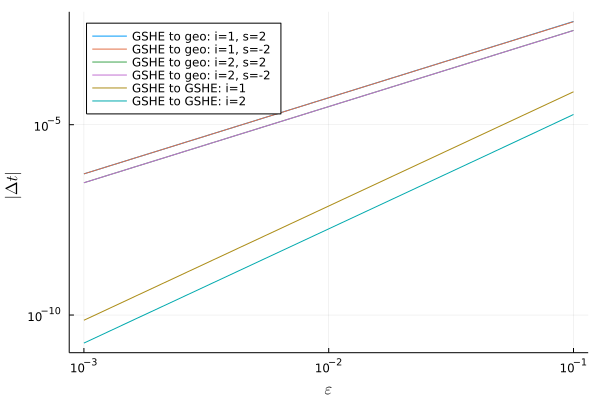

In [50]:
# Each row contains ψ, ρ, t, z, Δσmin, nloops
Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)
# Shape is  (Nsols, s = ± 2, Nϵs, 6). Last index same as above
Xgshe = GSHEIntegrator.solve_increasing(Xgeo, geometry, ϵs; verbose=false);


fig = Plots.plot(xlabel=L"\epsilon", ylabel=L"|\Delta t|", scale=:log10, yscale=:log10, legend=:topleft)
for i in 1:Nsols, (s, slabel) in enumerate([2, -2])
    dt = abs.(Xgshe[i,  s, :, 3] .- Xgeo[i, 3])
    Plots.plot!(fig, ϵs, dt, label="GSHE to geo: i=$i, s=$slabel")
end

for i in 1:Nsols
    dt = abs.(Xgshe[i,  1, :, 3] .- Xgshe[i, 2, :, 3])
    Plots.plot!(fig, ϵs, dt, label="GSHE to GSHE: i=$i")
end

display(fig)

In [62]:
αs, βs = GSHEIntegrator.fit_timing(ϵs, Xgeo, Xgshe, geometry; fit_gshe_gshe=true);
println("αs and βs, rows solutions and columns GSHE to GEO, GSHE to GEO and GSHE to GSHE")
flush(stdout)
display(αs[..,1])
display(βs[..,1])

αs and βs, rows solutions and columns GSHE to GEO, GSHE to GEO and GSHE to GSHE


2×3 Matrix{Float64}:
 2.00122  1.99878  3.00033
 2.00061  1.99955  3.00112

2×3 Matrix{Float64}:
 0.514854  0.507469  0.0732932
 0.300051  0.298175  0.0185016